In [2]:
"""
Title: PixelCNN
Author: [ADMoreau](https://github.com/ADMoreau)
Date created: 2020/05/17
Last modified: 2020/05/23
Description: PixelCNN implemented in Keras.
"""

"""
## Introduction
PixelCNN is a generative model proposed in 2016 by van den Oord et al.
(reference: [Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)).
It is designed to generate images (or other data types) iteratively
from an input vector where the probability distribution of prior elements dictates the
probability distribution of later elements. In the following example, images are generated
in this fashion, pixel-by-pixel, via a masked convolution kernel that only looks at data
from previously generated pixels (origin at the top left) to generate later pixels.
During inference, the output of the network is used as a probability ditribution
from which new pixel values are sampled to generate a new image
(here, with MNIST, the pixels values are either black or white).
"""

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
from keras.callbacks import History
import sfh
from sfh.model_utils import input_fn, predictor, pass_sample, finish_sample
import importlib
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)
print(tfp.__version__)


%pylab inline

#  Important !!!! path to shared tensorflow dataset
data_dir='/gpfsscratch/rech/qrc/commun/tensorflow_datasets'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.6.0
0.14.1
Populating the interactive namespace from numpy and matplotlib


In [2]:

# Code for the TCN adapted from https://github.com/philipperemy/keras-tcn

def residual_block(x, training, dilation_rate, nb_filters, kernel_size, padding,
                   activation='relu', dropout_rate=0, use_batch_norm=False):
    # type: (Layer, bool, int, int, int, str, str, float, str, bool) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN
    Args:
        x: The previous layer in the model
        training: boolean indicating whether the layer should behave in training mode or in inference mode
        dilation_rate: The dilation power of 2 we are using for this residual block
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        activation: The final activation used in o = Activation(x + F(x))
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
        use_batch_norm: Whether to use batch normalization in the residual layers or not.
    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """
    prev_x = x
    for k in range(2):
        x = tf.keras.layers.Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding,
                   activation=activation)(x)
        if use_batch_norm:
            x = tf.layers.batch_normalization(x)  # TODO should be WeightNorm here, but using batchNorm instead
        #x = tf.nn.relu(x)
        x = tf.keras.layers.SpatialDropout1D(rate=dropout_rate)(inputs=x, training=training)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = tf.keras.layers.Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = prev_x + x
    res_x = tf.keras.activations.relu(res_x)
    return res_x, x

def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations

    x = tf.keras.layers.Conv1D(nb_filters, 1, padding=padding)(x)
    skip_connections = []
    for s in range(nb_stacks):
        for d in dilations:
            x, skip_out = residual_block(training=training,
                                          dilation_rate=d,
                                          nb_filters=nb_filters,
                                          kernel_size=kernel_size,
                                          padding=padding,
                                          activation=activation,
                                          dropout_rate=dropout_rate,
                                          use_batch_norm=use_batch_norm)(x)
            skip_connections.append(skip_out)
    if use_skip_connections:
        x = tf.keras.layers.add(skip_connections)
    if not return_sequences:
        x = x[:, -1, :]
    return x

In [3]:
import tensorflow_datasets as tfds
dset = tfds.load('sfh_interp', split='train', data_dir=data_dir)
sample = list(dset.take(5))[3]

2021-12-09 21:45:11.115615: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 21:45:11.766462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1c:00.0, compute capability: 7.0
2021-12-09 21:45:12.118663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-09 21:45:12.167771: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the 

In [4]:
from sfh.models.pixelcnn import generate_model

pixel_cnn = generate_model(100)
pixel_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 101, 1)            0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 16)           64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 16)           784       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 32)           1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 64)           6208      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 128)          2

2021-12-09 14:58:04.839058: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [5]:
batch_size = 64
epochs = 100

dtrain = input_fn(mode='train', batch_size=batch_size, dataset_name='sfh_interp')
dval = input_fn(mode='val', batch_size=batch_size, dataset_name='sfh_interp')

history = History()

hist = pixel_cnn.fit(dtrain, 
                     epochs=epochs, 
                     #steps_per_epoch=num_train//batch_size, 
                     validation_data=dval,
                     callbacks=[history])

Epoch 1/100


2021-12-09 14:58:06.970330: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


269/269 [==============================] - 5s 6ms/step - loss: 106.1530 - val_loss: -23.6050
Epoch 2/100
269/269 [==============================] - 1s 5ms/step - loss: -43.8592 - val_loss: -64.7322
Epoch 3/100
269/269 [==============================] - 1s 5ms/step - loss: -68.6019 - val_loss: -84.0468
Epoch 4/100
269/269 [==============================] - 1s 5ms/step - loss: -72.3032 - val_loss: -63.5242
Epoch 5/100
269/269 [==============================] - 1s 5ms/step - loss: -79.4483 - val_loss: -97.0307
Epoch 6/100
269/269 [==============================] - 1s 5ms/step - loss: -73.1980 - val_loss: -78.5879
Epoch 7/100
269/269 [==============================] - 1s 5ms/step - loss: -88.9188 - val_loss: -104.0083
Epoch 8/100
269/269 [==============================] - 1s 5ms/step - loss: -89.6994 - val_loss: -97.9127
Epoch 9/100
269/269 [==============================] - 1s 5ms/step - loss: -87.1114 - val_loss: -67.1498
Epoch 10/100
269/269 [==============================] - 1s 5ms/ste

### Check learning curve

In [4]:
%matplotlib inline

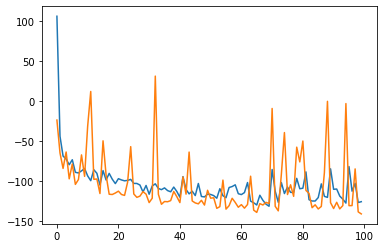

In [7]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### Pass sample

Feed a dataset sample to the network and visualize output

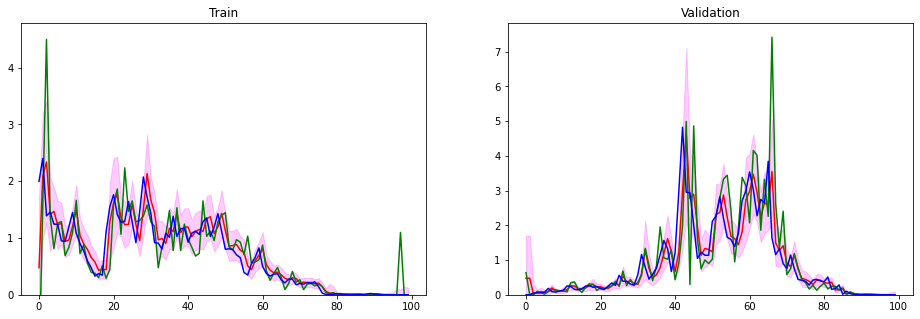

In [8]:
sample_train = list(dtrain.take(10))[3][0][0]
sample_val = list(dval.take(10))[3][0][0]
train_mean, train_std, train_pass = pass_sample(pixel_cnn, sample_train)
val_mean, val_std, val_pass = pass_sample(pixel_cnn, sample_val)

train_std = train_std.numpy().reshape((-1,))
train_mean = train_mean.numpy().reshape((-1,))
val_std = val_std.numpy().reshape((-1,))
val_mean = val_mean.numpy().reshape((-1,))

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(train_mean,'r')
ax[0].fill_between(np.linspace(0,99,100,endpoint=True), y1=train_mean+train_std, y2=train_mean-train_std, color='magenta', alpha=0.2)
ax[0].plot(train_pass.numpy().reshape((-1,)), 'g')
ax[0].plot(sample_train.numpy().reshape((-1,)), 'b')
ax[0].set_ylim(bottom=0.0)
ax[0].set_title('Train')
ax[1].plot(val_mean,'r')
ax[1].fill_between(np.linspace(0,99,100,endpoint=True), y1=val_mean+val_std, y2=val_mean-val_std, color='magenta', alpha=0.2)
ax[1].plot(val_pass.numpy().reshape((-1,)), 'g')
ax[1].plot(sample_val.numpy().reshape((-1,)), 'b')
ax[1].set_ylim(bottom=0.0)
ax[1].set_title('Validation')
plt.show()

### Predictor

A randomly generated SFR from the model

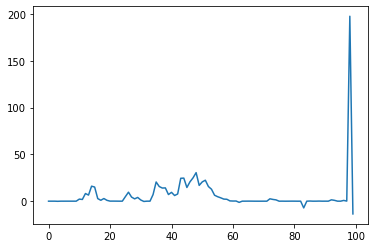

In [9]:
gen_sample = predictor(pixel_cnn, 1).reshape((-1,))
plt.plot(gen_sample)
plt.show()


### Finish sample

Take a part of a SFR sequence, and predicts the endplt.plot(sample['SFR_Max'].numpy().reshape((-1,)), 'b')

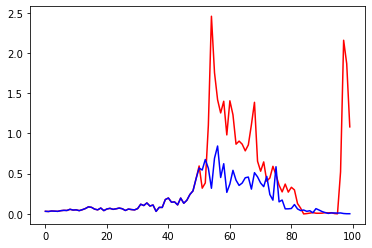

In [10]:
# TODO FIX MEEE
import importlib
import sys
sys.path.insert(0,'../sfh')
import model_utils
importlib.reload(sfh.model_utils)

gen_sample = model_utils.finish_sample(pixel_cnn, sample['SFR_Max'][:50]).reshape((-1,))
plt.plot(gen_sample, 'r')
plt.plot(sample['SFR_Max'].numpy().reshape((-1,)), 'b')
plt.show()


In [114]:
# np.histogram([float(np.max(ex['SFR_Max'])) for ex in dset.take(len(dset))], bins=50)

# CONDITIONAL MODEL + BETA DISTRIBUTION

In [15]:
%load_ext autoreload
%autoreload 2

importlib.reload(sfh.model_utils)
from sfh.model_utils import input_fn
batch_size=64
epochs=50
data_cond_train = input_fn(mode='train', batch_size=batch_size, dataset_name='sfh_interp', 
                           include_mass=True, arctan=True)
data_cond_val = input_fn(mode='train', batch_size=batch_size, dataset_name='sfh_interp', 
                         include_mass=True, arctan=True)
print(list(data_cond_val.take(1))[0][0].get_shape())
time = list(data_cond_val.take(1))[0][0][0,:,-1]
SFR = list(data_cond_val.take(1))[0][0][0,:,0]
Mstar0 = list(data_cond_val.take(1))[0][0][0,:,1]
SFR0 = list(data_cond_val.take(1))[0][0][0,:,2]
tf.print(SFR)
tf.print(Mstar0)
tf.print(SFR0)
tf.print(time)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2021-12-09 21:59:44.715290: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(64, 100, 4)


2021-12-09 21:59:44.997667: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-12-09 21:59:45.222345: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-12-09 21:59:45.438429: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. I

[0.17259405553071316 0.1819791851753825 0.13524537011589727 ... 0.0018669063029066063 6.3661977234636078e-06 6.3661977234636078e-06]
[-2.6837682630570519 -2.6837682630570519 -2.6837682630570519 ... -2.6837682630570519 -2.6837682630570519 -2.6837682630570519]
[0.035040394636792066 0.035040394636792066 0.035040394636792066 ... 0.035040394636792066 0.035040394636792066 0.035040394636792066]
[1 0.99056816101074219 0.97658687829971313 ... 0.077040337026119232 0.062542319297790527 0.047513857483863831]


2021-12-09 21:59:45.650321: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [16]:
import sfh
importlib.reload(sfh)
from sfh.models.pixelcnn_beta import generate_model

pixel_cnn_wmass = generate_model(100, 
                                 n_channels=4)
pixel_cnn_wmass.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 101, 4)            0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 100, 4)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 100, 16)           208       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 100, 16)           784       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 100, 32)           1568      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 100, 64)           6208      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 100, 128)         

In [37]:
history3 = History()
# Learning rate schedule
LEARNING_RATE=0.0002
LEARNING_RATE_EXP_DECAY=0.995
lr_decay = keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

hist3 = pixel_cnn_wmass.fit(data_cond_train, 
                     epochs=200,
                     #steps_per_epoch=num_train//batch_size, 
                     validation_data=data_cond_val,
                     callbacks=[history3, lr_decay])

Epoch 1/200

Epoch 00001: LearningRateScheduler setting learning rate to 0.0002.
269/269 [==============================] - 4s 13ms/step - loss: -291.8198 - val_loss: -292.9973
Epoch 2/200

Epoch 00002: LearningRateScheduler setting learning rate to 0.000199.
269/269 [==============================] - 4s 13ms/step - loss: -293.0566 - val_loss: -293.3961
Epoch 3/200

Epoch 00003: LearningRateScheduler setting learning rate to 0.000198005.
269/269 [==============================] - 4s 13ms/step - loss: -293.0533 - val_loss: -292.9482
Epoch 4/200

Epoch 00004: LearningRateScheduler setting learning rate to 0.000197014975.
269/269 [==============================] - 4s 13ms/step - loss: -293.6037 - val_loss: -293.6636
Epoch 5/200

Epoch 00005: LearningRateScheduler setting learning rate to 0.000196029900125.
269/269 [==============================] - 4s 13ms/step - loss: -293.6647 - val_loss: -294.1346
Epoch 6/200

Epoch 00006: LearningRateScheduler setting learning rate to 0.00019504975062

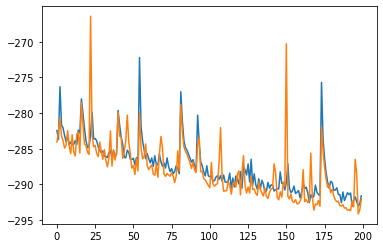

In [34]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


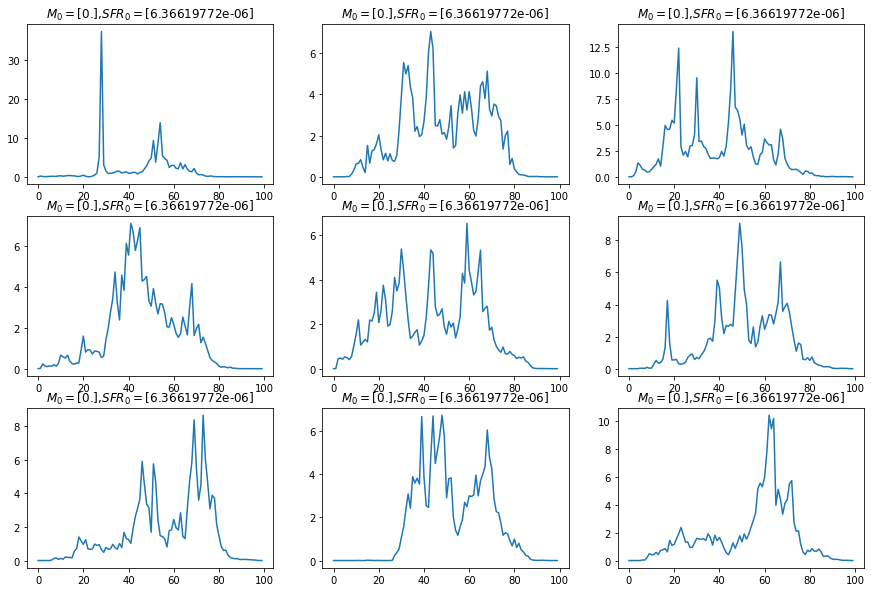

In [35]:
%load_ext autoreload
%autoreload 2
from sfh import model_utils
from sfh.model_utils import predictor, pass_sample
importlib.reload(sfh.model_utils)
nlin, ncol = 3, 3
fig,ax = plt.subplots(nlin,ncol, figsize=(15,10))
for i in range(nlin):
    for j in range(ncol):
        gen_sample, M_z0, sfr_z0 = predictor(pixel_cnn_wmass, 1, n_channels=4, mode='sample',
                                             arctan=True, time=list(data_cond_val.take(1))[0][0][0,:,-1],
                                             M0=1e10, SFR0=1e-5)
        ax[i,j].plot(gen_sample.reshape((-1,)))
        ax[i,j].set_title(r'$M_0=${},$SFR_0=${}'.format(M_z0, sfr_z0))
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


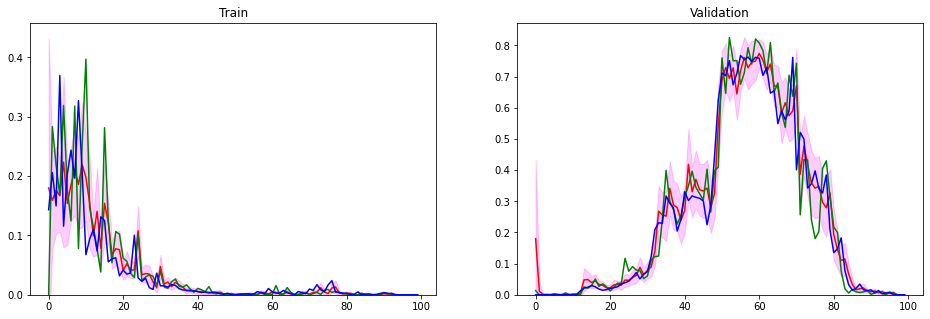

In [20]:
%load_ext autoreload
%autoreload 2
from sfh import model_utils
from sfh.model_utils import predictor, pass_sample

sample_train = list(data_cond_train.take(10))[3][0][0]
sample_val = list(data_cond_val.take(10))[3][0][0]
train_mean, train_std, train_pass = pass_sample(pixel_cnn_wmass, sample_train)
val_mean, val_std, val_pass = pass_sample(pixel_cnn_wmass, sample_val)

train_std = train_std.numpy().reshape((-1,))
train_mean = train_mean.numpy().reshape((-1,))
val_std = val_std.numpy().reshape((-1,))
val_mean = val_mean.numpy().reshape((-1,))

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(train_mean,'r')
ax[0].fill_between(np.linspace(0,99,100,endpoint=True), y1=train_mean+train_std, y2=train_mean-train_std, color='magenta', alpha=0.2)
ax[0].plot(train_pass.numpy().reshape((-1,)), 'g')
ax[0].plot(sample_train.numpy()[...,0], 'b')
ax[0].set_ylim(bottom=0.0)
ax[0].set_title('Train')
ax[1].plot(val_mean,'r')
ax[1].fill_between(np.linspace(0,99,100,endpoint=True), y1=val_mean+val_std, y2=val_mean-val_std, color='magenta', alpha=0.2)
ax[1].plot(val_pass.numpy().reshape((-1,)), 'g')
ax[1].plot(sample_val.numpy()[...,0], 'b')
ax[1].set_ylim(bottom=0.0)
ax[1].set_title('Validation')
plt.show()

In [143]:
importlib.reload(sfh.model_utils)

gen_sample = model_utils.finish_sample(pixel_cnn_wmass, sample_val, pred_start=50, n_channels=3, ).reshape((-1,))
plt.plot(gen_sample, 'r')
plt.plot(sample['SFR_Max'].numpy().reshape((-1)), 'b')
plt.show()



TypeError: finish_sample() got an unexpected keyword argument 'pred_start'

In [17]:
"""
## Build the model based on the original paper
"""

inputs = keras.Input(shape=(28,1))
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

#out = keras.layers.Conv1D(
#    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
#)(x)

out = tfp.layers.MixtureNormal(num_components, event_shape)(x)


pixel_cnn = keras.Model(inputs, out)

negloglik = lambda y, q: -q.log_prob(y)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss=negloglik)

pixel_cnn.summary()

In [52]:
from tensorflow.keras.utils import plot_model

plot_model(pixel_cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
pixel_cnn.fit(
    x=data, y=data, batch_size=128, epochs=50, validation_split=0.1, verbose=2
)


In [ ]:
"""
## Demonstration
The PixelCNN cannot generate the full image at once. Instead, it must generate each pixel in
order, append the last generated pixel to the current image, and feed the image back into the
model to repeat the process.
"""

from IPython.display import Image, display

# Create an empty array of pixels.
batch = 4
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )



In [ ]:

def deprocess_image(x):
    # Stack the single channeled black and white image to rgb values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.preprocessing.image.save_img(
        "generated_image_{}.png".format(i), deprocess_image(np.squeeze(pic, -1))
    )

display(Image("generated_image_0.png"))
display(Image("generated_image_1.png"))
display(Image("generated_image_2.png"))
display(Image("generated_image_3.png"))